## Poisonous Mushroom Pipeline

In [7]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import joblib
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [8]:
#import dataset
dataset = pd.read_csv('../raw_data/secondary_data.csv', sep=";", low_memory=False)

In [9]:
df = dataset.copy()

In [10]:
drop_columns = ['gill-spacing', 'stem-root', 
                'stem-surface', 'veil-type', 
                'veil-color', 'spore-print-color',
                ]
df.drop(columns=drop_columns, inplace=True)

In [11]:
gender = {'p': 1,'e': 0}
df['class'] = [gender[item] for item in df['class']]

In [12]:
X = df.drop(columns='class')
y = df['class']

In [13]:
preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(), make_column_selector(dtype_include="float64")),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include="object"))
    ],remainder='passthrough')


preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('num_encoder', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12d1b5c10>),
                                ('cat_encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12d6fbdf0>)])

In [14]:
pd.DataFrame(preprocessor.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.240155,0.499705,0.164469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.261782,0.530366,0.175055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.220949,0.524764,0.170725,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.222563,0.464917,0.153787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.230148,0.487323,0.165528,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=1000,
                                                      criterion='gini', 
                                                      max_depth= 30,
                                                      random_state=123)),
])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12d1b5c10>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12d6fbdf0>)])),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=1000,
                                        random_state=123))])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [17]:
fitted_pipe = pipe.fit(X_train, y_train)

In [18]:
# Use pickle to save model for next usage.
filename = 'rf_model.pkl'
with open('./'+filename, 'wb') as file:
    pickle.dump(fitted_pipe, file) 

In [20]:
with open('../rf_model.pkl', 'rb') as f:
    model = pickle.load(f)
    
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12d49f940>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12d49f220>)])),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=1000,
                                        random_state=123))])

In [22]:
model.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12d49f940>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12d49f220>)])),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=1000,
                                        random_state=123))])>

In [ ]:
#filename = 'rf_model_jb.pkl'
#joblib.dump(model, filename)

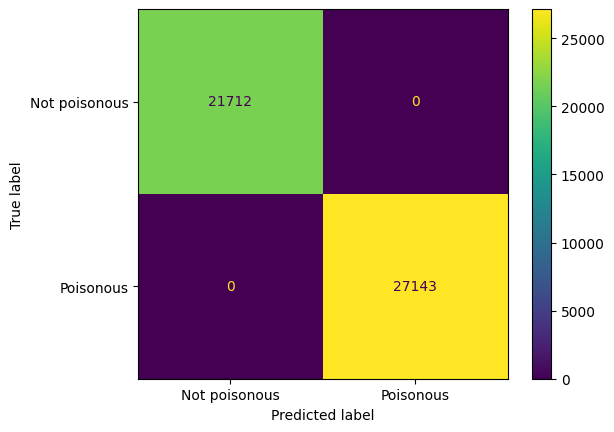

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

In [ ]:
acc_test = model.score(X_test, y_test)
print('accuracy:',round(acc_test,4)*100,'%')

accuracy: 99.98 %


In [ ]:
from sklearn.metrics import classification_report

print("Random Forest classification report:")
print(classification_report(y_test, model.predict(X_test)))

Random Forest classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5469
           1       1.00      1.00      1.00      6745

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



In [ ]:
predicted_test = model.predict(X_test)
matrix_test = confusion_matrix(y_test, predicted_test)

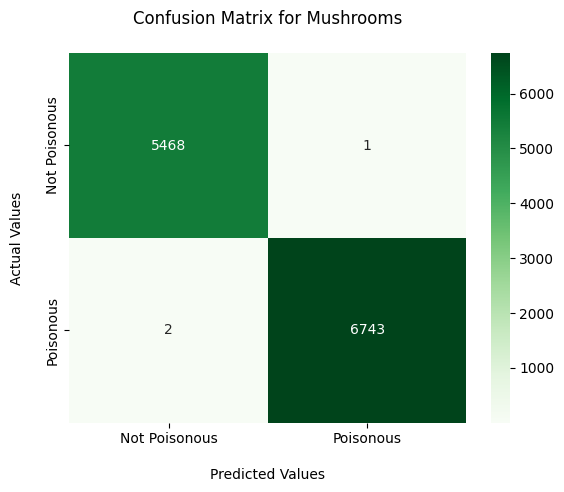

In [ ]:
ax = sns.heatmap(matrix_test, annot=True, cmap="Greens", fmt="g")

ax.set_title("Confusion Matrix for Mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not Poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not Poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

Inspecting the ROC curve for better recall

In [ ]:
probabilities = model.predict_proba(X_train)
probabilities_df = pd.DataFrame(probabilities)

In [ ]:
fpr, tpr, threshold = roc_curve(y_train, probabilities[:,1])

In [ ]:
roc_df = pd.DataFrame({"fpr":fpr,"tpr":tpr,"threshold":threshold})


In [ ]:
roc_df[roc_df["tpr"] == 1].nlargest(1, "threshold")

,fpr,tpr,threshold
3274,0.0,1.0,0.715756


In [ ]:
optimum_threshold_value = roc_df.threshold[3274]

#### Setting the ROC Threshold for Random Froest Classifier

In [ ]:
new_predictions = (probabilities_df.loc[:,1] >= optimum_threshold_value).astype("int")

In [ ]:
print(f"Probability: {probabilities_df.loc[3310, 1]}")
print(f"New Value: {new_predictions.loc[3310]}")

Probability: 0.9985654645055754
New Value: 1


In [ ]:
cf_matrix = confusion_matrix(y_train, new_predictions)

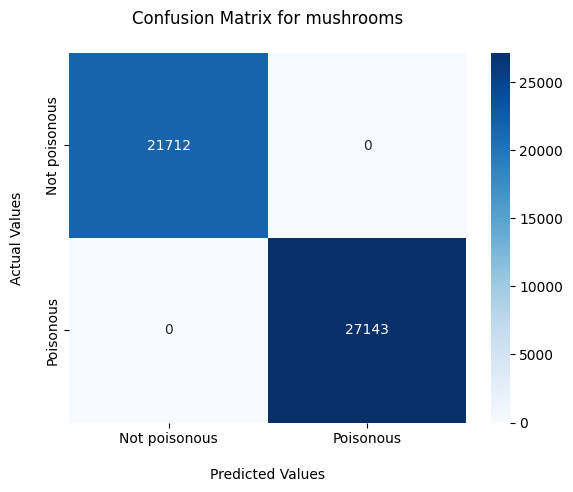

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
probabilities_test_set = model.predict_proba(X_test)

# Use the probabilities and the threshold to make the predictions.
predicted_test = (probabilities_test_set[:,1] >= optimum_threshold_value).astype("int")

In [ ]:
matrix_test = confusion_matrix(y_test, predicted_test)

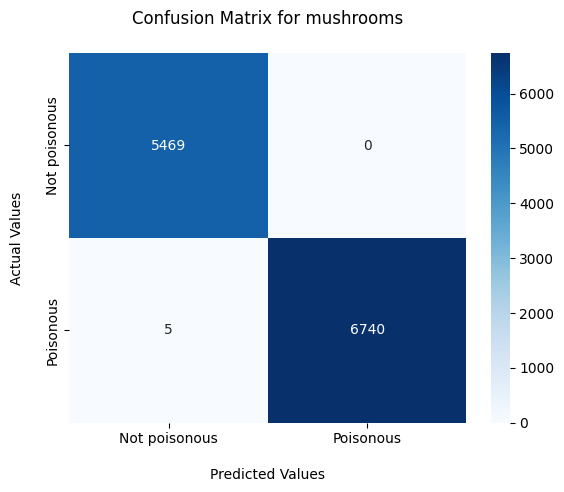

In [ ]:
ax = sns.heatmap(matrix_test, annot=True, cmap="Blues", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

Weird ASF